# 🔧 LangGraph Graph API

## 📚 개요

이 튜토리얼은 LangGraph의 핵심인 Graph API의 모든 개념을 깊이 있게 다룹니다. LangGraph는 에이전트 워크플로우를 **그래프**로 모델링하며, 이를 통해 복잡한 상태 기계와 멀티 에이전트 시스템을 구축할 수 있습니다.

## 🎯 학습 목표

1. **그래프 기본 개념** 이해 - State, Nodes, Edges의 핵심 구성요소
2. **상태 관리** 마스터 - 스키마 정의, 리듀서 함수, 메시지 처리
3. **노드** 심화 학습 - 다양한 노드 타입과 캐싱
4. **엣지와 라우팅** - 조건부 라우팅과 동적 제어 흐름
5. **고급 기능** - Send, Command를 활용한 복잡한 워크플로우

## 🔑 핵심 개념 미리보기

```
┌─────────────────────────────────────────────────────────┐
│                    LangGraph Graph API                   │
├──────────────┬──────────────┬──────────────────────────┤
│    State     │    Nodes     │         Edges            │
├──────────────┼──────────────┼──────────────────────────┤
│ • Schema     │ • Functions  │ • Normal Edges           │
│ • Reducers   │ • START/END  │ • Conditional Edges      │
│ • Messages   │ • Caching    │ • Entry/Exit Points      │
│              │              │ • Send & Command         │
└──────────────┴──────────────┴──────────────────────────┘
```

## 💡 중요 원칙

> **"노드는 작업을 수행하고, 엣지는 다음에 무엇을 할지 결정한다"**
> 
> _Nodes do the work, edges tell what to do next_

## 환경 설정

In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Tutorial


---

# Part 1: 그래프 기본 개념 🌐

## 1.1 그래프란 무엇인가?

LangGraph의 핵심은 에이전트 워크플로우를 **그래프**로 모델링하는 것입니다. 그래프는 세 가지 핵심 구성요소로 이루어집니다:

1. **State (상태)**: 애플리케이션의 현재 스냅샷을 나타내는 공유 데이터 구조
2. **Nodes (노드)**: 에이전트의 로직을 인코딩하는 함수들
3. **Edges (엣지)**: 현재 상태를 기반으로 다음 실행할 노드를 결정하는 함수들

### 그래프 알고리즘의 동작 원리

LangGraph는 Google의 Pregel 시스템에서 영감을 받은 **메시지 패싱** 알고리즘을 사용합니다:

1. **Super-step**: 그래프 노드에 대한 단일 반복
2. **병렬 실행**: 같은 super-step의 노드들은 병렬로 실행
3. **순차 실행**: 다른 super-step의 노드들은 순차적으로 실행
4. **종료 조건**: 모든 노드가 비활성 상태이고 전송 중인 메시지가 없을 때

In [3]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# 간단한 그래프 예제
class SimpleState(TypedDict):
    """Simple state with a single field"""

    message: str


# StateGraph 생성
graph_builder = StateGraph(SimpleState)


# 노드 함수 정의
def processor(state: SimpleState):
    """Process the message in the state"""
    # 노드는 현재 상태를 입력으로 받고 업데이트를 반환
    return {"message": state["message"] + " - processed"}


# 노드 추가
graph_builder.add_node("processor", processor)

# 엣지 추가 (진입점과 종료점)
graph_builder.add_edge(START, "processor")
graph_builder.add_edge("processor", END)

# 그래프 컴파일 - 필수!
graph = graph_builder.compile()

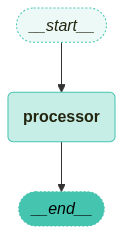

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [5]:
# 그래프 실행
result = graph.invoke({"message": "Hello LangGraph"})
print(f"결과: {result}")

결과: {'message': 'Hello LangGraph - processed'}


### 1.2 그래프 컴파일

그래프를 사용하기 전에 **반드시 컴파일**해야 합니다. 컴파일 과정에서:

1. 그래프 구조의 기본 검증 (고아 노드 없음 등)
2. 런타임 인자 지정 (체크포인터, 브레이크포인트 등)
3. 실행 가능한 그래프 객체 생성

In [6]:
from langgraph.checkpoint.memory import InMemorySaver

# 체크포인터와 함께 컴파일
memory = InMemorySaver()

graph_with_memory = graph_builder.compile(
    checkpointer=memory,  # 상태 저장을 위한 체크포인터
    # interrupt_before=["processor"],  # 특정 노드 전에 중단 (디버깅용)
    # interrupt_after=["processor"],   # 특정 노드 후에 중단
)

print("✅ 체크포인터가 있는 그래프 컴파일 완료!")

✅ 체크포인터가 있는 그래프 컴파일 완료!


---

# Part 2: State (상태) 심화 학습 📊

## 2.1 State 스키마 정의

State는 그래프의 스키마와 리듀서 함수로 구성됩니다. 스키마는 TypedDict, dataclass, 또는 Pydantic 모델로 정의할 수 있습니다.

In [7]:
from typing import Annotated, List
from dataclasses import dataclass, field
from pydantic import BaseModel


# 방법 1: TypedDict (가장 일반적, 성능 우수)
class TypedDictState(TypedDict):
    """State using TypedDict"""

    count: int
    items: List[str]


# 방법 2: dataclass (기본값 지원)
@dataclass
class DataclassState:
    """State using dataclass with default values"""

    count: int = 0
    items: List[str] = field(default_factory=list)


# 방법 3: Pydantic (재귀적 검증, 성능은 떨어짐)
class PydanticState(BaseModel):
    """State using Pydantic for validation"""

    count: int = 0
    items: List[str] = []


print("✅ 세 가지 방식의 State 스키마 정의 완료!")

✅ 세 가지 방식의 State 스키마 정의 완료!


## 2.2 Reducers (리듀서)

리듀서는 노드의 업데이트가 State에 어떻게 적용되는지 정의합니다. 각 State 키는 독립적인 리듀서 함수를 가질 수 있습니다.

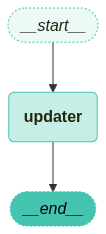

In [8]:
from operator import add


# 기본 리듀서 vs 커스텀 리듀서
class StateWithReducers(TypedDict):
    """State with custom reducers"""

    # 기본 리듀서: 값을 덮어씀
    current_value: int

    # add 리듀서: 리스트를 연결
    history: Annotated[List[str], add]

    # 커스텀 리듀서: 최대값 유지
    max_value: Annotated[int, lambda x, y: max(x, y)]


# 그래프 생성
builder = StateGraph(StateWithReducers)


def update_values(state: StateWithReducers):
    """Update various state values"""
    return {
        "current_value": 10,  # 덮어쓰기
        "history": ["새 항목"],  # 추가
        "max_value": 15,  # 최대값과 비교
    }


builder.add_node("updater", update_values)
builder.add_edge(START, "updater")
builder.add_edge("updater", END)

graph = builder.compile()

# 그래프 시각화
visualize_graph(graph)

In [9]:
# 초기 상태로 실행
initial_state = {"current_value": 5, "history": ["초기 항목"], "max_value": 20}

result = graph.invoke(initial_state)
print("\n리듀서 적용 결과:")
print(f"  current_value: 5 → {result['current_value']} (덮어쓰기)")
print(f"  history: {result['history']} (추가)")
print(f"  max_value: {result['max_value']} (최대값 유지)")


리듀서 적용 결과:
  current_value: 5 → 10 (덮어쓰기)
  history: ['초기 항목', '새 항목'] (추가)
  max_value: 20 (최대값 유지)


## 2.3 메시지 처리

대화형 AI에서는 메시지 리스트를 State에 저장하는 것이 일반적입니다. LangGraph는 이를 위한 특별한 리듀서를 제공합니다.

In [10]:
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState


# 방법 1: add_messages 리듀서 사용
class ChatState(TypedDict):
    """State with message handling"""

    messages: Annotated[List[AnyMessage], add_messages]
    metadata: dict


# 방법 2: MessagesState 상속 (더 간단)
class ExtendedChatState(MessagesState):
    """Extended state inheriting from MessagesState"""

    # messages 키는 이미 정의되어 있음
    metadata: dict

In [11]:
from langchain_core.runnables import RunnableConfig

# 메시지 처리 예제
builder = StateGraph(ChatState)


def process_chat(state: ChatState):
    """Process chat messages"""
    # 마지막 메시지 접근
    last_message = state["messages"][-1]

    # 응답 생성
    response = AIMessage(content=f"{last_message.content}")

    return {
        "messages": [response],  # add_messages가 자동으로 추가
        "metadata": {"processed": True},
    }


builder.add_node("chat", process_chat)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

memory = InMemorySaver()

chat_graph = builder.compile(checkpointer=memory)

In [12]:
config = RunnableConfig(configurable={"thread_id": "1"})

# 실행
result = chat_graph.invoke(
    {
        "messages": [HumanMessage(content="안녕하세요")],
        "metadata": {},
        "user_info": {"name": "사용자"},
    },
    config=config,
)

print("\n메시지 처리 결과:")
for msg in result["messages"]:
    print(f"  [{msg.__class__.__name__}]: {msg.content}")


메시지 처리 결과:
  [HumanMessage]: 안녕하세요
  [AIMessage]: 안녕하세요


## 2.4 다중 스키마 (입력/출력 분리)

때로는 그래프의 입력과 출력 스키마를 다르게 하고 싶을 수 있습니다. 또한 내부 노드 간 통신을 위한 프라이빗 스키마도 정의할 수 있습니다.

**InputState와 OutputState**

노드가 전체 스테이트와 상호작용하는 동안, LangGraph는 스테이트그래프를 초기화할 때 명시적인 입력 스테이트와 출력 스테이트 스키마를 정의할 수 있게 해줍니다. 이를 통해 그래프가 호출될 때 예상되는 데이터와 완료 시 반환되는 데이터를 명확하게 구분할 수 있습니다.
- `InputState`: 이 스키마는 그래프가 실행될 때 입력으로 예상되는 데이터의 구조와 유형을 정의합니다. 그래프가 처리를 시작하기 위해 수신할 것으로 예상되는 데이터에 대한 계약 역할을 합니다.
- `OutputState`: 이 스키마는 그래프가 최종 결과로 생성할 데이터의 구조와 유형을 정의합니다. 사용자 또는 후속 시스템이 완료된 그래프 실행에서 받을 수 있는 것을 명확히 합니다.

In [23]:
# 그래프의 입력 스키마
class InputState(TypedDict):
    """Input schema - what users provide"""

    user_input: str


# 그래프의 출력 스키마
class OutputState(TypedDict):
    """Output schema - what users receive"""

    graph_output: str


# 내부에서 사용되는 State
class InternalState(TypedDict):
    """Internal schema - full state for processing"""

    user_input: str
    internal_state: str


# Private State
class PrivateState(TypedDict):
    """Private schema - for internal node communication"""

    private_state: str

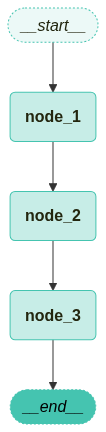

node_1: {'user_input': '사용자 입력'}
node_2: {'user_input': '사용자 입력', 'internal_state': '사용자 입력(node_1 에서 처리됨)'}
node_3: {'private_state': 'PRIVATE: 사용자 입력(node_1 에서 처리됨) (node_2 에서 처리됨)'}

다중 스키마 결과: {'graph_output': '최종 결과: PRIVATE: 사용자 입력(node_1 에서 처리됨) (node_2 에서 처리됨) (node_3 에서 처리됨)'}


In [25]:
# 다중 스키마를 사용하는 그래프
builder = StateGraph(
    InternalState,
    input_schema=InputState,  # 입력 스키마 지정
    output_schema=OutputState,  # 출력 스키마 지정
)


def node_1(state: InputState) -> InternalState:
    """First node - reads from InputState, writes to InternalState"""
    # InputState를 받지만 InternalState의 키에 쓸 수 있음
    print(f"node_1: {state}")
    return {
        "user_input": state["user_input"],
        "internal_state": state["user_input"] + "(node_1 에서 처리됨)",
    }


def node_2(state: InternalState) -> PrivateState:
    """Second node - reads from InternalState, writes to PrivateState"""
    print(f"node_2: {state}")
    # 새로운 state 채널(temp_data) 추가 가능
    return {"private_state": f"PRIVATE: {state['internal_state']} (node_2 에서 처리됨)"}


def node_3(state: PrivateState) -> OutputState:
    """Final node - reads from PrivateState, writes to OutputState"""
    print(f"node_3: {state}")
    return {"graph_output": f"최종 결과: {state['private_state']} (node_3 에서 처리됨)"}


# 노드와 엣지 추가
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

multi_schema_graph = builder.compile()

visualize_graph(multi_schema_graph)

# 실행 - 입력은 InputState 형식
result = multi_schema_graph.invoke({"user_input": "사용자 입력"})

# 출력은 OutputState 형식
print(f"\n다중 스키마 결과: {result}")

---

# Part 3: Nodes (노드) 심화 학습 🔨

## 3.1 노드 함수의 인자

노드는 Python 함수(동기/비동기)로, 다음 인자를 받을 수 있습니다:

1. `state`: 그래프의 현재 상태
2. `config`: 설정 정보 (thread_id, 추적 정보 등)
3. `runtime`: 런타임 컨텍스트와 기타 정보

별도의 ConfigSchema 를 정의하여 Node 에 추가로 제공할 수 있습니다.(선택 사항이지만 권장)

In [30]:
from typing_extensions import TypedDict


class ConfigSchema(TypedDict):
    my_runtime_value: str
    another_setting: bool


class MyState(MessagesState):
    pass

config를 두 번째 인자로 받도록 노드 함수를 정의
- config 인수는 사용자 정의 구성 값이 저장되는 “configurable” 키를 포함하여 다양한 런타임 설정이 포함된 사전과 같은 구조의 RunnableConfig 객체가 됩니다.

In [ ]:
from langchain_core.runnables import RunnableConfig


# state 와 config 를 받는 노드 함수 정의
def my_node(state: MyState, config: RunnableConfig):
    """
    Example node function that demonstrates how to access custom configuration values.

    Args:
        state (MyState): The current state of the graph.
        config (RunnableConfig): Configuration object containing runtime and user-defined settings.

    Returns:
        dict: Updated state dictionary.
    """
    # config["configurable"] 딕셔너리에서 사용자 정의 설정값을 가져옵니다.
    runtime_value = config["configurable"].get("runtime_value", "")
    setting_value = config["configurable"].get("setting_value", "")

    # runtime_value 값이 있으면 해당 값을 출력합니다.
    if runtime_value:
        print(f"runtime_value: {runtime_value}")

    # setting_value 값이 있으면 해당 값을 출력합니다.
    if setting_value:
        print(f"setting_value: {setting_value}")

    # 현재 state 값을 출력합니다.
    print(f"state: {state}")

    # 새로운 키와 값을 포함하는 상태를 반환합니다.
    return {"updated_key": "new_value"}

StateGraph를 빌드할 때 config_schema를 지정합니다(선택 사항이지만 권장)
- 이렇게 하면 LangGraph가 정의된 스키마에 대해 제공된 구성의 유효성을 검사할 수 있습니다.

In [47]:
from langgraph.graph import StateGraph

builder = StateGraph(MyState, context_schema=ConfigSchema)
builder.add_node("my_node", my_node)
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)

graph = builder.compile()

원하는 구성으로 컴파일된 그래프를 호출합니다. 호출 또는 스트림 메서드의 `config` 인수에 사전을 전달하고 사용자 정의 값을 `"configurable"` 키 아래에 배치합니다.

In [48]:
graph = builder.compile()
result = graph.invoke(
    {"messages": [HumanMessage(content="안녕하세요")]},
    config={
        "configurable": {"runtime_value": "I love LangGraph", "setting_value": 123}
    },
)

runtime_value: I love LangGraph
setting_value: 123
state: {'messages': [HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='d39d3794-825a-4415-a003-0bb6e937692c')]}


## 3.2 특수 노드: START와 END

- **START**: 사용자 입력이 그래프로 전달되는 시작점
- **END**: 그래프 실행이 종료되는 지점

In [49]:
# START와 END 사용 예제
class FlowState(TypedDict):
    """State for flow control example"""

    value: int
    path: List[str]


builder = StateGraph(FlowState)


def start_processing(state: FlowState):
    """Initial processing node"""
    return {"value": state["value"] * 2, "path": ["start"]}


def middle_processing(state: FlowState):
    """Middle processing node"""
    return {"value": state["value"] + 10, "path": state["path"] + ["middle"]}


def final_processing(state: FlowState):
    """Final processing node"""
    return {"value": state["value"] // 2, "path": state["path"] + ["final"]}


# 노드 추가
builder.add_node("start_node", start_processing)
builder.add_node("middle_node", middle_processing)
builder.add_node("final_node", final_processing)

# 플로우 정의
builder.add_edge(START, "start_node")  # 진입점
builder.add_edge("start_node", "middle_node")
builder.add_edge("middle_node", "final_node")
builder.add_edge("final_node", END)  # 종료점

flow_graph = builder.compile()

# 실행
result = flow_graph.invoke({"value": 5, "path": []})
print(f"\n플로우 실행 결과:")
print(f"  초기값: 5")
print(f"  최종값: {result['value']}")
print(f"  경로: {' → '.join(result['path'])}")


플로우 실행 결과:
  초기값: 5
  최종값: 10
  경로: start → middle → final


## 3.3 노드 캐싱

LangGraph는 노드 실행 결과를 캐싱하여 성능을 향상시킬 수 있습니다.

`CachePolicy` 를 사용하여 캐시 정책을 정의
- `key_func`: 노드의 입력에서 캐시 키를 생성하는 함수입니다.
- `ttl`: 캐시 항목의 유효 기간(초)입니다. 없음이면 항목이 만료되지 않습니다.

In [ ]:
import time
from langgraph.cache.memory import InMemoryCache
from langgraph.types import CachePolicy


class CacheState(TypedDict):
    """State for caching example"""

    x: int
    result: int


builder = StateGraph(CacheState)


def expensive_computation(state: CacheState) -> dict:
    """Expensive computation that we want to cache"""
    print(f"  🔄 무거운 계산 실행 중... (x={state['x']})")
    time.sleep(3)  # 무거운 작업 시뮬레이션
    return {"result": state["x"] * state["x"]}


# 캐시 정책과 함께 노드 추가
builder.add_node(
    "expensive_node",
    expensive_computation,
    cache_policy=CachePolicy(
        ttl=None,  # 60초 동안 캐시 유지, None 이면 만료시간 없음
        # key_func=lambda x: hash(x["x"])  # 커스텀 캐시 키 생성 함수
    ),
)

builder.add_edge(START, "expensive_node")
builder.add_edge("expensive_node", END)

# 캐시와 함께 컴파일
cached_graph = builder.compile(cache=InMemoryCache())

print("\n캐싱 테스트:")
print("첫 번째 실행")
start_time = time.time()
result1 = cached_graph.invoke({"x": 10})
print(f"  결과: {result1['result']}, 소요 시간: {time.time() - start_time:.1f}초")

print("\n두 번째 실행")
start_time = time.time()
result2 = cached_graph.invoke({"x": 10})
print(f"  결과: {result2['result']}, 소요 시간: {time.time() - start_time:.1f}초")

print("\n다른 입력으로 실행")
start_time = time.time()
result3 = cached_graph.invoke({"x": 20})
print(f"  결과: {result3['result']}, 소요 시간: {time.time() - start_time:.1f}초")


캐싱 테스트:
첫 번째 실행
  🔄 무거운 계산 실행 중... (x=10)
  결과: 100, 소요 시간: 3.0초

두 번째 실행
  결과: 100, 소요 시간: 0.0초

다른 입력으로 실행
  🔄 무거운 계산 실행 중... (x=20)
  결과: 400, 소요 시간: 3.0초


In [71]:
print("\n캐싱 테스트:")

result1 = None
%time result1 = cached_graph.invoke({"x": 10})
print(f"  결과: {result1['result']}")


캐싱 테스트:
CPU times: user 891 μs, sys: 365 μs, total: 1.26 ms
Wall time: 941 μs
  결과: 100


---

# Part 4: Edges (엣지) 심화 학습 🔀

엣지는 그래프의 로직 라우팅과 실행 중단을 정의합니다. 노드 간 통신 방식을 결정하는 핵심 요소입니다.

## 4.1 일반 엣지 (Normal Edges)

In [75]:
class EdgeState(TypedDict):
    """State for edge examples"""

    value: int
    history: List[str]


builder = StateGraph(EdgeState)


# 노드 정의
def node_a(state: EdgeState):
    """Node A"""
    return {"value": state["value"] + 1, "history": state["history"] + ["A"]}


def node_b(state: EdgeState):
    """Node B"""
    return {"value": state["value"] * 2, "history": state["history"] + ["B"]}


def node_c(state: EdgeState):
    """Node C"""
    return {"value": state["value"] - 3, "history": state["history"] + ["C"]}


# 노드 추가
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# 일반 엣지 - 항상 A → B → C 순서로 실행
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", END)

normal_edge_graph = builder.compile()

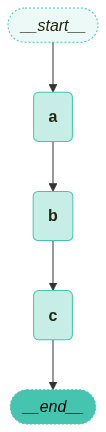

In [76]:
# 그래프 시각화
visualize_graph(normal_edge_graph)

In [77]:
result = normal_edge_graph.invoke({"value": 10, "history": []})
print(f"일반 엣지 결과:")
print(f"  경로: {' → '.join(result['history'])}")
print(f"  최종값: {result['value']}")

일반 엣지 결과:
  경로: A → B → C
  최종값: 19


## 4.2 조건부 엣지 (Conditional Edges)

조건부 엣지는 상태에 따라 다른 노드로 라우팅합니다.

In [185]:
from typing import Literal

builder = StateGraph(EdgeState)

# 노드들 재사용
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)


# 라우팅 함수 정의
def routing_function(state: EdgeState) -> Literal["b", "c"]:
    """Route based on state value"""
    if state["value"] > 15:
        return "b"  # 큰 값은 B로
    else:
        return "c"  # 작은 값은 C로


# 조건부 엣지 추가
builder.add_edge(START, "a")
builder.add_conditional_edges("a", routing_function)  # 소스 노드  # 라우팅 함수
builder.add_edge("b", END)
builder.add_edge("c", END)

conditional_graph = builder.compile()

# 다른 값으로 테스트
print("조건부 라우팅 테스트:\n")

for initial_value in [10, 20]:
    result = conditional_graph.invoke({"value": initial_value, "history": []})
    print(f"초기값 {initial_value}:")
    print(f"  경로: {' → '.join(result['history'])}")
    print(f"  최종값: {result['value']}\n")

조건부 라우팅 테스트:

초기값 10:
  경로: A → C
  최종값: 8

초기값 20:
  경로: A → B
  최종값: 42



## 4.3 매핑을 사용한 조건부 엣지

In [79]:
# 매핑을 사용한 더 복잡한 라우팅
builder = StateGraph(EdgeState)

builder.add_node(
    "start", lambda s: {"value": s["value"], "history": s["history"] + ["start"]}
)
builder.add_node(
    "process_high",
    lambda s: {"value": s["value"] * 10, "history": s["history"] + ["high"]},
)
builder.add_node(
    "process_medium",
    lambda s: {"value": s["value"] * 5, "history": s["history"] + ["medium"]},
)
builder.add_node(
    "process_low",
    lambda s: {"value": s["value"] * 2, "history": s["history"] + ["low"]},
)


def categorize_value(state: EdgeState) -> str:
    """Categorize value into high/medium/low"""
    if state["value"] > 100:
        return "high"
    elif state["value"] > 50:
        return "medium"
    else:
        return "low"


# 매핑을 사용한 조건부 엣지
builder.add_edge(START, "start")
builder.add_conditional_edges(
    "start",
    categorize_value,
    {"high": "process_high", "medium": "process_medium", "low": "process_low"},
)

# 모든 처리 노드는 END로
for node in ["process_high", "process_medium", "process_low"]:
    builder.add_edge(node, END)

mapped_graph = builder.compile()

# 테스트
print("매핑 기반 라우팅 테스트:\n")
for value in [30, 75, 150]:
    result = mapped_graph.invoke({"value": value, "history": []})
    print(f"초기값 {value}: {' → '.join(result['history'])}, 결과: {result['value']}")

매핑 기반 라우팅 테스트:

초기값 30: start → low, 결과: 60
초기값 75: start → medium, 결과: 375
초기값 150: start → high, 결과: 1500


## 4.4 병렬 실행

한 노드가 여러 개의 나가는 엣지를 가지면, 대상 노드들이 병렬로 실행됩니다.

In [ ]:
from typing import List


class ParallelState(TypedDict):
    """State for parallel execution"""

    input: int
    nodes: str
    results: Annotated[List[AnyMessage], add_messages]


builder = StateGraph(ParallelState)


def splitter(state: ParallelState):
    """Split into multiple paths"""
    return {"results": ["분할 완료"]}


def parallel_a(state: ParallelState):
    """Parallel processing A"""
    print("[Node A]")
    time.sleep(0.5)  # 작업 시뮬레이션
    return {"results": [f"A: {state['input'] * 2}"]}


def parallel_b(state: ParallelState):
    """Parallel processing B"""
    print("[Node B]")
    time.sleep(1.0)  # 작업 시뮬레이션
    return {"results": [f"B: {state['input'] + 10}"]}


def parallel_c(state: ParallelState):
    """Parallel processing C"""
    print("[Node C]")
    time.sleep(2.0)  # 작업 시뮬레이션
    return {"results": [f"C: {state['input'] ** 2}"]}


def merger(state: ParallelState):
    """Merge results"""
    return {"results": ["병합 완료"]}


# 노드 추가
builder.add_node("splitter", splitter)
builder.add_node("parallel_a", parallel_a)
builder.add_node("parallel_b", parallel_b)
builder.add_node("parallel_c", parallel_c)
builder.add_node("merger", merger)


# 병렬 실행을 위한 조건부 엣지
def parallel_routing(state: ParallelState) -> List[str]:
    """Route to multiple nodes for parallel execution"""

    print(f"[Parallel Routing] {state['nodes']}")

    if state["nodes"].upper() == "A":
        return ["parallel_a"]
    elif state["nodes"].upper() == "B":
        return ["parallel_b"]
    elif state["nodes"].upper() == "C":
        return ["parallel_c"]
    elif state["nodes"].upper() == "AB" or state["nodes"].upper() == "BA":
        return ["parallel_a", "parallel_b"]
    elif state["nodes"].upper() == "AC" or state["nodes"].upper() == "CA":
        return ["parallel_a", "parallel_c"]
    elif state["nodes"].upper() == "BC" or state["nodes"].upper() == "CB":
        return ["parallel_b", "parallel_c"]
    elif state["nodes"].upper() == "ABC":
        return ["parallel_a", "parallel_b", "parallel_c"]


builder.add_edge(START, "splitter")
builder.add_conditional_edges("splitter", parallel_routing)

# 모든 병렬 노드는 merger로
builder.add_edge("parallel_a", "merger")
builder.add_edge("parallel_b", "merger")
builder.add_edge("parallel_c", "merger")
builder.add_edge("merger", END)

parallel_graph = builder.compile()

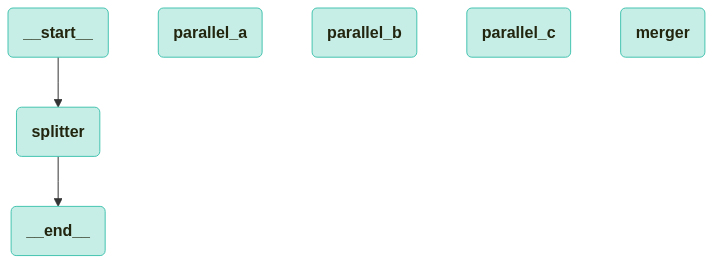

In [175]:
# 그래프 시각화
visualize_graph(parallel_graph, xray=True)

In [ ]:
from langchain_teddynote.messages import invoke_graph

start_time = time.time()
invoke_graph(
    parallel_graph, inputs={"input": 1, "nodes": "ca", "results": []}, config=None
)
elapsed = time.time() - start_time

print(f"\n실행 시간: {elapsed:.1f}초 (병렬 실행으로 시간 단축)")

[Parallel Routing] ca

🔄 Node: splitter 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
분할 완료
[Node A]
[Node C]

🔄 Node: parallel_a 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
A: 2

🔄 Node: parallel_c 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
C: 1

🔄 Node: merger 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
병합 완료

실행 시간: 2.0초 (병렬 실행으로 시간 단축)


---

# Part 5: Send - 동적 라우팅 📤

`Send`는 실행 시점에 동적으로 엣지를 생성하고, 각각 다른 상태로 여러 노드를 호출할 수 있게 합니다. Map-Reduce 패턴에 특히 유용합니다.

Send 클래스는 StateGraph의 조건부 엣지 내에서 다음 단계에서 **사용자 정의 상태를 가진 노드를 동적으로 호출** 하는 데 사용됩니다.

중요한 점은 전송된 상태가 핵심 그래프의 상태와 다를 수 있으므로 유연하고 동적인 워크플로우 관리가 가능하다는 점입니다.

예를 들어 그래프에서 동일한 노드를 다른 상태로 병렬로 여러 번 호출한 후 그 결과를 다시 기본 그래프의 상태로 집계하는 ‘맵 축소’ 워크플로우를 들 수 있습니다.

In [ ]:
from typing import TypedDict, List, Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import random

# ChatGPT 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)


# State 정의
class JokeGeneratorState(TypedDict):
    """농담 생성 상태"""

    jokes: Annotated[List[AnyMessage], add_messages]
    current_subject: str
    attempt_count: int


class SingleJokeState(TypedDict):
    """개별 농담 생성 상태"""

    subject: str
    joke_number: int


# StateGraph 생성
builder = StateGraph(JokeGeneratorState)


def initialize_state(state: JokeGeneratorState) -> dict:
    """초기 상태 설정"""
    subjects = ["프로그래머", "AI", "파이썬", "자바스크립트", "데이터베이스"]
    selected_subject = random.choice(subjects)

    print(f"🎯 선택된 주제: {selected_subject}")
    print("=" * 50)

    return {"current_subject": selected_subject, "jokes": [], "attempt_count": 0}


def generate_single_joke(state: SingleJokeState) -> dict:
    """LLM을 사용하여 개별 농담 생성"""
    messages = [
        SystemMessage(
            content="당신은 재미있는 IT 농담을 만드는 코미디언입니다. 짧고 재치있는 농담을 한국어로 만들어주세요."
        ),
        HumanMessage(
            content=f"{state['subject']}에 대한 재미있는 농담을 하나만 만들어주세요. (농담 #{state['joke_number']})"
        ),
    ]

    response = llm.invoke(messages)
    joke = response.content.strip()

    print(f"🎭 농담 #{state['joke_number']}: {joke}")

    return {"jokes": [joke]}


def update_attempt_count(state: JokeGeneratorState) -> dict:
    """시도 횟수 업데이트"""
    attempt_count = state.get("attempt_count", 0) + 1
    current_joke_count = len(state.get("jokes", []))

    print(f"\n📊 현재 농담 개수: {current_joke_count}/3")
    print(f"🔄 시도 횟수: {attempt_count}")

    return {"attempt_count": attempt_count}


def route_based_on_count(state: JokeGeneratorState) -> List[Send]:
    """농담 개수에 따라 Send로 라우팅"""
    current_joke_count = len(state.get("jokes", []))

    if current_joke_count < 3:
        # 3개 미만이면 부족한 만큼 generate_joke로 Send
        sends = []
        for i in range(current_joke_count + 1, 4):  # 3개까지 생성
            sends.append(
                Send(
                    "generate_joke",
                    {"subject": state["current_subject"], "joke_number": i},
                )
            )
        print(f"➡️ {len(sends)}개의 농담을 추가로 생성합니다...")
        return sends
    else:
        # 3개 이상이면 finalize로
        print("✅ 농담 3개 생성 완료! 최종 정리 단계로 이동합니다.")
        return [Send("finalize", state)]


def finalize_jokes(state: JokeGeneratorState) -> dict:
    """최종 농담 정리"""
    print("\n" + "=" * 50)
    print(f"🎉 최종 농담 컬렉션 ({state['current_subject']} 주제)")
    print("=" * 50)

    jokes = state.get("jokes", [])
    for i, joke in enumerate(jokes, 1):
        print(f"\n농담 {i}: {joke}")

    summary = f"\n\n📝 총 {len(jokes)}개의 농담이 생성되었습니다. (시도 횟수: {state.get('attempt_count', 1)}회)"

    return {"jokes": jokes + [summary]}


# 노드 추가
builder.add_node("initialize", initialize_state)
builder.add_node("generate_joke", generate_single_joke)
builder.add_node("update_count", update_attempt_count)
builder.add_node("finalize", finalize_jokes)

# 엣지 추가
builder.add_edge(START, "initialize")
builder.add_edge("initialize", "update_count")

# update_count 노드 이후 conditional_edges로 Send 처리
builder.add_conditional_edges(
    "update_count",
    route_based_on_count,  # Send 리스트를 반환하는 라우팅 함수
    ["generate_joke", "finalize"],  # 가능한 목적지 노드들
)

# generate_joke 완료 후 다시 update_count로
builder.add_edge("generate_joke", "update_count")

# finalize 후 종료
builder.add_edge("finalize", END)

# 그래프 컴파일
joke_generator = builder.compile()

In [220]:
from langchain_teddynote.messages import stream_graph

stream_graph(
    joke_generator,
    inputs={"current_subject": "AI", "jokes": [], "attempt_count": 0},
    config=None,
)

🎯 선택된 주제: 파이썬

📊 현재 농담 개수: 0/3
🔄 시도 횟수: 1
➡️ 3개의 농담을 추가로 생성합니다...

🔄 Node: generate_joke 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
왜 파이썬 프로그래머는 항상 행복할까요? 

코드가 "들여쓰기"만 하면 되니까요!🎭 농담 #2: 왜 파이썬 프로그래머는 항상 행복할까요? 

코드가 "들여쓰기"만 하면 되니까요!
파이썬이 좋아하는 운동은 뭐게요? 

코드 스프린트! 🐍🏃‍♂️🎭 농담 #3: 파이썬이 좋아하는 운동은 뭐게요? 

코드 스프린트! 🐍🏃‍♂️
왜 파이썬 프로그래머는 항상 차갑게 지내나요?  
왜냐하면 그들은 항상 "import antigravity"를 하고 있으니까요! 🐍✨🎭 농담 #1: 왜 파이썬 프로그래머는 항상 차갑게 지내나요?  
왜냐하면 그들은 항상 "import antigravity"를 하고 있으니까요! 🐍✨

📊 현재 농담 개수: 3/3
🔄 시도 횟수: 2
✅ 농담 3개 생성 완료! 최종 정리 단계로 이동합니다.

🎉 최종 농담 컬렉션 (파이썬 주제)

농담 1: content='왜 파이썬 프로그래머는 항상 차갑게 지내나요?  \n왜냐하면 그들은 항상 "import antigravity"를 하고 있으니까요! 🐍✨' additional_kwargs={} response_metadata={} id='332610c3-8c06-436e-bed5-ffe6c57f653e'

농담 2: content='왜 파이썬 프로그래머는 항상 행복할까요? \n\n코드가 "들여쓰기"만 하면 되니까요!' additional_kwargs={} response_metadata={} id='48296063-487b-49cc-bd6c-9f30d324f8aa'

농담 3: content='파이썬이 좋아하는 운동은 뭐게요? \n\n코드 스프린트! 🐍🏃\u200d♂️' additional_kwargs={} response_metadata={} id='889b4d

---

# Part 6: Command - 제어 흐름과 상태 업데이트 결합 🎮

`Command`를 사용하면 노드 내에서 상태 업데이트와 라우팅을 동시에 수행할 수 있습니다.

제어 흐름(엣지)과 상태 업데이트(노드)를 결합하는 것이 유용할 수 있습니다. 

예를 들어, 동일한 노드에서 상태 업데이트와 다음 노드로 이동할 노드 결정을 모두 수행하고자 할 수 있습니다. 

LangGraph는 노드 함수에서 Command 객체를 반환하여 이를 수행하는 방법을 제공합니다.

In [ ]:
from langgraph.types import Command
from typing import Literal
from typing_extensions import TypedDict


class CommandState(TypedDict):
    """State for Command examples"""

    value: int


def my_node(state: CommandState) -> Command[Literal["my_other_node"]]:
    """Node that makes decisions and updates state"""
    return Command(
        # state update
        update={"foo": "bar"},
        # control flow
        goto="my_other_node",
    )

Command를 사용하면 동적 제어 흐름 동작(조건부 에지와 동일)을 구현할 수도 있습니다.

In [238]:
def my_node(state: CommandState) -> Command[Literal["my_other_node"]]:
    if state["foo"] == "bar":
        return Command(update={"foo": "baz"}, goto="my_other_node")

**상위 그래프의 노드로 이동하기**

하위 그래프를 사용하는 경우 하위 그래프 내의 노드에서 다른 하위 그래프(즉, 상위 그래프의 다른 노드)로 이동하고 싶을 수 있습니다. 이렇게 하려면 Command에서 graph=Command.PARENT를 지정하면 됩니다.

In [ ]:
def my_node(state: CommandState) -> Command[Literal["other_subgraph"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # where `other_subgraph` is a node in the parent graph
        graph=Command.PARENT,
    )

`Command` 를 사용하여 `update` 와 `goto` 를 동시에 사용하는 예제

In [239]:
from langgraph.types import Command


class CommandState(TypedDict):
    """State for Command examples"""

    value: int
    message: str
    path: List[str]


builder = StateGraph(CommandState)


# Command를 반환하는 노드
def decision_node(
    state: CommandState,
) -> Command[Literal["success", "failure", "retry"]]:
    """Node that makes decisions and updates state"""
    value = state["value"]

    if value > 100:
        return Command(
            # 상태 업데이트
            update={
                "message": "값이 너무 큽니다",
                "path": state["path"] + ["decision"],
            },
            # 라우팅
            goto="failure",
        )
    elif value > 50:
        return Command(
            update={
                "message": "처리 성공",
                "value": value * 2,
                "path": state["path"] + ["decision"],
            },
            goto="success",
        )
    else:
        return Command(
            update={
                "message": "재시도 필요",
                "value": value + 30,
                "path": state["path"] + ["decision"],
            },
            goto="retry",
        )


def success_node(state: CommandState):
    """Success handler"""
    return {"message": f"✅ {state['message']}", "path": state["path"] + ["success"]}


def failure_node(state: CommandState):
    """Failure handler"""
    return {"message": f"❌ {state['message']}", "path": state["path"] + ["failure"]}


def retry_node(state: CommandState) -> Command[Literal["decision"]]:
    """Retry handler - goes back to decision"""
    return Command(
        update={"message": "재시도 중...", "path": state["path"] + ["retry"]},
        goto="decision",  # 다시 결정 노드로
    )


# 노드 추가
builder.add_node("decision", decision_node)
builder.add_node("success", success_node)
builder.add_node("failure", failure_node)
builder.add_node("retry", retry_node)

# 엣지 추가
builder.add_edge(START, "decision")
builder.add_edge("success", END)
builder.add_edge("failure", END)
# retry는 Command로 decision으로 돌아감

command_graph = builder.compile()

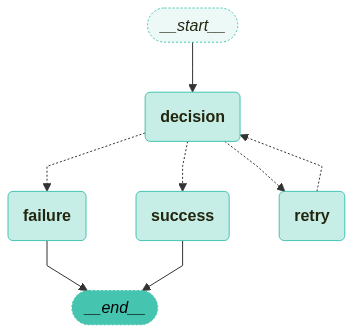

In [240]:
visualize_graph(command_graph)

In [241]:
# 그래프 실행
test_values = [30, 75, 150]
for val in test_values:
    result = command_graph.invoke({"value": val, "message": "", "path": []})
    print(f"초기값 {val}:")
    print(f"  경로: {' → '.join(result['path'])}")
    print(f"  메시지: {result['message']}")
    print(f"  최종값: {result['value']}\n")

초기값 30:
  경로: decision → retry → decision → success
  메시지: ✅ 처리 성공
  최종값: 120

초기값 75:
  경로: decision → success
  메시지: ✅ 처리 성공
  최종값: 150

초기값 150:
  경로: decision → failure
  메시지: ❌ 값이 너무 큽니다
  최종값: 150



## 6.1 Command vs 조건부 엣지

### 언제 Command를 사용할까?
- 상태 업데이트와 라우팅을 **동시에** 수행해야 할 때
- 멀티 에이전트 핸드오프에서 정보 전달이 필요할 때

### 언제 조건부 엣지를 사용할까?
- 상태 업데이트 없이 **라우팅만** 필요할 때
- 단순한 분기 로직

In [ ]:
# 멀티 에이전트 핸드오프 예제
class AgentState(TypedDict):
    """State for multi-agent system"""

    task: str
    current_agent: str
    result: str
    handoff_info: dict


builder = StateGraph(AgentState)


def analyst_agent(state: AgentState) -> Command[Literal["engineer", "designer"]]:
    """Analyst agent that delegates tasks"""
    task = state["task"]

    if "코드" in task or "구현" in task:
        return Command(
            update={
                "current_agent": "engineer",
                "handoff_info": {
                    "priority": "high",
                    "language": "Python",
                    "analyzed_by": "analyst",
                },
            },
            goto="engineer",
        )
    else:
        return Command(
            update={
                "current_agent": "designer",
                "handoff_info": {"style": "modern", "analyzed_by": "analyst"},
            },
            goto="designer",
        )


def engineer_agent(state: AgentState):
    """Engineer agent"""
    info = state["handoff_info"]
    return {"result": f"엔지니어가 {info.get('language', 'unknown')}로 구현 완료"}


def designer_agent(state: AgentState):
    """Designer agent"""
    info = state["handoff_info"]
    return {"result": f"디자이너가 {info.get('style', 'unknown')} 스타일로 디자인 완료"}


# 노드 추가
builder.add_node("analyst", analyst_agent)
builder.add_node("engineer", engineer_agent)
builder.add_node("designer", designer_agent)

# 엣지 추가
builder.add_edge(START, "analyst")
builder.add_edge("engineer", END)
builder.add_edge("designer", END)

agent_graph = builder.compile()

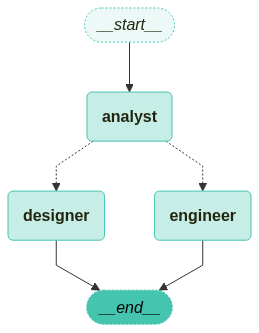

In [243]:
visualize_graph(agent_graph)

In [245]:
# 테스트
print("멀티 에이전트 핸드오프 테스트:\n")

tasks = ["로그인 기능 구현", "홈페이지 디자인"]
for task in tasks:
    result = agent_graph.invoke(
        {"task": task, "current_agent": "analyst", "result": "", "handoff_info": {}}
    )
    print(f"작업: {task}")
    print(f"  담당 에이전트: {result['current_agent']}")
    print(f"  전달 정보: {result['handoff_info']}")
    print(f"  결과: {result['result']}\n")

멀티 에이전트 핸드오프 테스트:

작업: 로그인 기능 구현
  담당 에이전트: engineer
  전달 정보: {'priority': 'high', 'language': 'Python', 'analyzed_by': 'analyst'}
  결과: 엔지니어가 Python로 구현 완료

작업: 홈페이지 디자인
  담당 에이전트: designer
  전달 정보: {'style': 'modern', 'analyzed_by': 'analyst'}
  결과: 디자이너가 modern 스타일로 디자인 완료



---

# Part 7: 고급 기능 🚀

## 재귀 제한 (Recursion Limit)

무한 루프를 방지하기 위해 그래프 실행의 최대 super-step 수를 제한할 수 있습니다.

In [252]:
class LoopState(TypedDict):
    """State for loop example"""

    counter: int
    history: List[int]


builder = StateGraph(LoopState)


def increment_node(state: LoopState) -> Command[Literal["increment", "end"]]:
    """Node that increments counter"""
    new_counter = state["counter"] + 1

    print(f"new_counter: {new_counter}")

    if new_counter < 10:  # 의도적으로 높은 목표 설정
        return Command(
            update={
                "counter": new_counter,
                "history": state["history"] + [new_counter],
            },
            goto="increment",  # 자기 자신으로 루프
        )
    else:
        return Command(update={"counter": new_counter}, goto="end")


def end_node(state: LoopState):
    """End node"""
    return {"history": state["history"] + [999]}


builder.add_node("increment", increment_node)
builder.add_node("end", end_node)
builder.add_edge(START, "increment")
builder.add_edge("end", END)

loop_graph = builder.compile()

# 재귀 제한 설정
print("재귀 제한 테스트:\n")

try:
    # 재귀 제한 5로 실행
    result = loop_graph.invoke(
        {"counter": 0, "history": []}, config={"recursion_limit": 5}  # 최대 5번만 실행
    )
except Exception as e:
    print(f"❌ 에러 발생: {e}")

재귀 제한 테스트:

new_counter: 1
new_counter: 2
new_counter: 3
new_counter: 4
new_counter: 5
❌ 에러 발생: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


In [254]:
# 충분한 재귀 제한으로 실행
result = loop_graph.invoke(
    {"counter": 0, "history": []}, config={"recursion_limit": 100}
)
print(f"\n✅ 성공: counter={result['counter']}, 실행 횟수={len(result['history'])}")

new_counter: 1
new_counter: 2
new_counter: 3
new_counter: 4
new_counter: 5
new_counter: 6
new_counter: 7
new_counter: 8
new_counter: 9
new_counter: 10

✅ 성공: counter=10, 실행 횟수=10
